# Inland Waterways Flow Visualization by Country

This notebook analyzes and visualizes inland waterway (IWW) freight flows for a selected country. It integrates port and channel infrastructure data, OD (Origin-Destination) matrices, and the IWW network to provide insights into the distribution and magnitude of flows through each channel. The workflow includes data loading, network construction, OD matrix preparation, shortest path calculation, flow aggregation, visualization, and summary statistics. The output includes maps and tables summarizing flows for each channel, with a focus on the selected country.


## 1. Import Required Libraries

This section imports all necessary Python libraries and utility functions, and loads the country boundaries dataset. It ensures the spatial data is in the correct coordinate reference system and filters the boundaries to the European region, preparing the context for subsequent IWW flow analysis.


In [1]:
# HIDE CODE
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pathlib import Path

import sys
from miraca_book.download import download
sys.path.append(str(Path().resolve().parent))

from utils.miraca_flow_utils import (
    plot_edges_by_flow_thickness, add_flow_to_edges, assemble_od_paths, 
    build_igraph_from_edges, get_country_bounds, print_network_flow_summary,
    load_europe_countries, convert_crs
)

warnings.filterwarnings('ignore')

outpath = Path('~/.miraca').expanduser() / "output"
outpath.mkdir(exist_ok=True, parents=True)
base_path = download('https://zenodo.org/records/18428552/files/MIRACA_Transport_Flow_Model.zip?download=1') / 'data'

In [2]:
# Load European countries using shared function
europe_countries = load_europe_countries(base_path)

Loaded 54 countries in Europe region


## 2. Load IWW Network Data

This section loads the inland waterway network data, including edges (channels), nodes, and OD (Origin-Destination) matrices for freight. It also extracts the ports from the node data and sets the selected country for analysis.


In [3]:
print("Loading IWW data...")

# Load data with CRS conversion
edges_gdf = convert_crs(gpd.read_parquet(base_path / "Infra_BE/belgium_iww_edges.parquet"), 4326)
nodes_gdf = convert_crs(gpd.read_parquet(base_path / "Infra_BE/belgium_iww_nodes.parquet"), 4326)
od_flows = pd.read_parquet(base_path / "ODs_BE/belgium_iww_freight_OD.parquet")

# Extract ports
iww_ports_gdf = convert_crs(nodes_gdf[nodes_gdf['feature'] == 'port'].copy(), 4326)

# Set the selected country
SELECTED_COUNTRY = "Belgium"

print(f"✓ Loaded {len(iww_ports_gdf)} IWW ports")
print(f"✓ Loaded {len(od_flows)} OD pairs")

Loading IWW data...
✓ Loaded 23 IWW ports
✓ Loaded 1739 OD pairs


## 3. Prepare OD Matrix

This section prepares the OD matrix for routing by mapping OD codes to node IDs, cleaning the data, and ensuring all flows are valid and ready for shortest path calculation.


In [4]:
print("Preparing OD matrix...")

# Map OD codes to node IDs directly
od_flows['from_id'] = od_flows['from_id'].astype(str).str.upper().str.strip()
od_flows['to_id'] = od_flows['to_id'].astype(str).str.upper().str.strip()

# Map to node IDs
od_flows['from_node'] = od_flows['from_id']
od_flows['to_node'] = od_flows['to_id']

# Drop unmatched ODs
before = len(od_flows)
od_flows = od_flows.dropna(subset=['from_node', 'to_node']).copy()
od_flows['from_node'] = od_flows['from_node'].astype(str)
od_flows['to_node'] = od_flows['to_node'].astype(str)
od_flows['value'] = pd.to_numeric(od_flows['value'], errors='coerce').fillna(0.0)
od_flows = od_flows[od_flows['value'] > 0].copy()

dropped = before - len(od_flows)
if dropped:
    print(f"⚠ Dropped {dropped} ODs (unmatched or zero value)")

print(f"✓ {len(od_flows)} valid OD pairs ready for routing")
print(f"✓ Total flow: {od_flows['value'].sum():,.0f} ths tons/year")

Preparing OD matrix...
✓ 1739 valid OD pairs ready for routing
✓ Total flow: 5,460 ths tons/year


## 4. Build Graph with igraph

This section constructs the IWW network graph using the igraph library, based on the loaded edges and nodes. It checks the connectivity of the network and provides information about connected components.


In [5]:
print("Building IWW graph with igraph...")

# Determine node ID column
node_id_col = 'node_id' 

# Build graph assuming equal shipping speed for all waterways
graph_result = build_igraph_from_edges(edges_gdf, 'from_node', 'to_node', nodes_gdf, node_id_col, weight_col='length')
if graph_result is None:
    raise ValueError("build_igraph_from_edges returned None. Check for node ID mismatches, missing columns, or data issues above.")

g, node_index, edges_gdf = graph_result

print(f"✓ Graph built: {g.vcount()} nodes, {g.ecount()} edges")
print(f"✓ Graph is {'connected' if g.is_connected() else 'disconnected'}")

# Get connected components info
if not g.is_connected():
    comps = g.connected_components()
    comp_sizes = sorted(comps.sizes(), reverse=True)
    print(f"  Largest component: {comp_sizes[0]} nodes ({100*comp_sizes[0]/g.vcount():.1f}%)")
    print(f"  Number of components: {len(comp_sizes)}")


Building IWW graph with igraph...
✓ Graph built: 6846 nodes, 6839 edges
✓ Graph is disconnected
  Largest component: 6716 nodes (98.1%)
  Number of components: 8


## 5. Calculate Shortest Paths for All OD Pairs

This section calculates the shortest paths for all valid OD pairs in the network, assigns stable edge IDs, and merges OD attributes for further analysis. It also provides statistics on path lengths and unreachable pairs.


In [6]:
print("Calculating shortest paths for all OD pairs...")

# Assign stable edge IDs
edges_gdf['edge_id'] = np.arange(len(edges_gdf), dtype=int)
g.es['edge_id'] = edges_gdf['edge_id'].tolist()

# Calculate paths
paths_df = assemble_od_paths(
    od_df=od_flows[['from_node', 'to_node']].dropna(),
    g=g, 
    node_index=node_index, 
    weight_attr='weight', 
    edge_id_attr='edge_id'
)

print(f"✓ Calculated {len(paths_df)} paths")

# Merge OD attributes (value, optional origin_sector)
merge_cols = ['from_node', 'to_node', 'value']
if 'origin_sector' in od_flows.columns:
    merge_cols.append('origin_sector')

paths_df = paths_df.merge(od_flows[merge_cols], on=['from_node', 'to_node'], how='left')

# Statistics
paths_df['path_length'] = paths_df['edge_path'].apply(len)
print(f"\nPath statistics:")
print(f"  Mean path length: {paths_df['path_length'].mean():.1f} edges")
print(f"  Max path length: {paths_df['path_length'].max()} edges")
print(f"  Empty paths (unreachable): {(paths_df['path_length'] == 0).sum()}")

Calculating shortest paths for all OD pairs...
✓ Calculated 1739 paths

Path statistics:
  Mean path length: 1025.6 edges
  Max path length: 3119 edges
  Empty paths (unreachable): 0


## 6. Aggregate Flows on Edges

This section aggregates the assigned flows from all OD paths onto the network edges, producing total and commodity-specific flows for each channel. The results are attached to the edge GeoDataFrame for visualization and reporting.


In [7]:
print("Aggregating flows on network edges...")

n_edges = len(edges_gdf)
edge_flow = np.zeros(n_edges, dtype=float)
edge_flow_by_comm = {}

# Aggregate total flow and per-commodity flow
for _, r in paths_df.iterrows():
    v = float(r.get('value', 0.0) or 0.0)
    ep = r.get('edge_path', None)
    
    # Add to total flow
    add_flow_to_edges(edge_flow, ep, v)
    
    # Add to commodity-specific flow
    if 'origin_sector' in paths_df.columns:
        comm = str(r.get('origin_sector', 'UNKNOWN'))
        if comm not in edge_flow_by_comm:
            edge_flow_by_comm[comm] = np.zeros(n_edges, dtype=float)
        add_flow_to_edges(edge_flow_by_comm[comm], ep, v)

# Attach flows to edges_gdf
edges_gdf['flow'] = edge_flow

# Add per-commodity columns
for comm, arr in edge_flow_by_comm.items():
    col = 'flow_' + ''.join(ch if ch.isalnum() else '_' for ch in comm).lower()
    edges_gdf[col] = arr

print(f"  Total flow on network: {edge_flow.sum():,.0f} ths tons/year")

Aggregating flows on network edges...
  Total flow on network: 20,407,051 ths tons/year


## 7. Create Flow Visualization

This section visualizes the aggregated flows on the IWW network using a map, where channel thickness and color represent flow magnitude and corridor, respectively. The map is zoomed to the selected country and saved as an image.


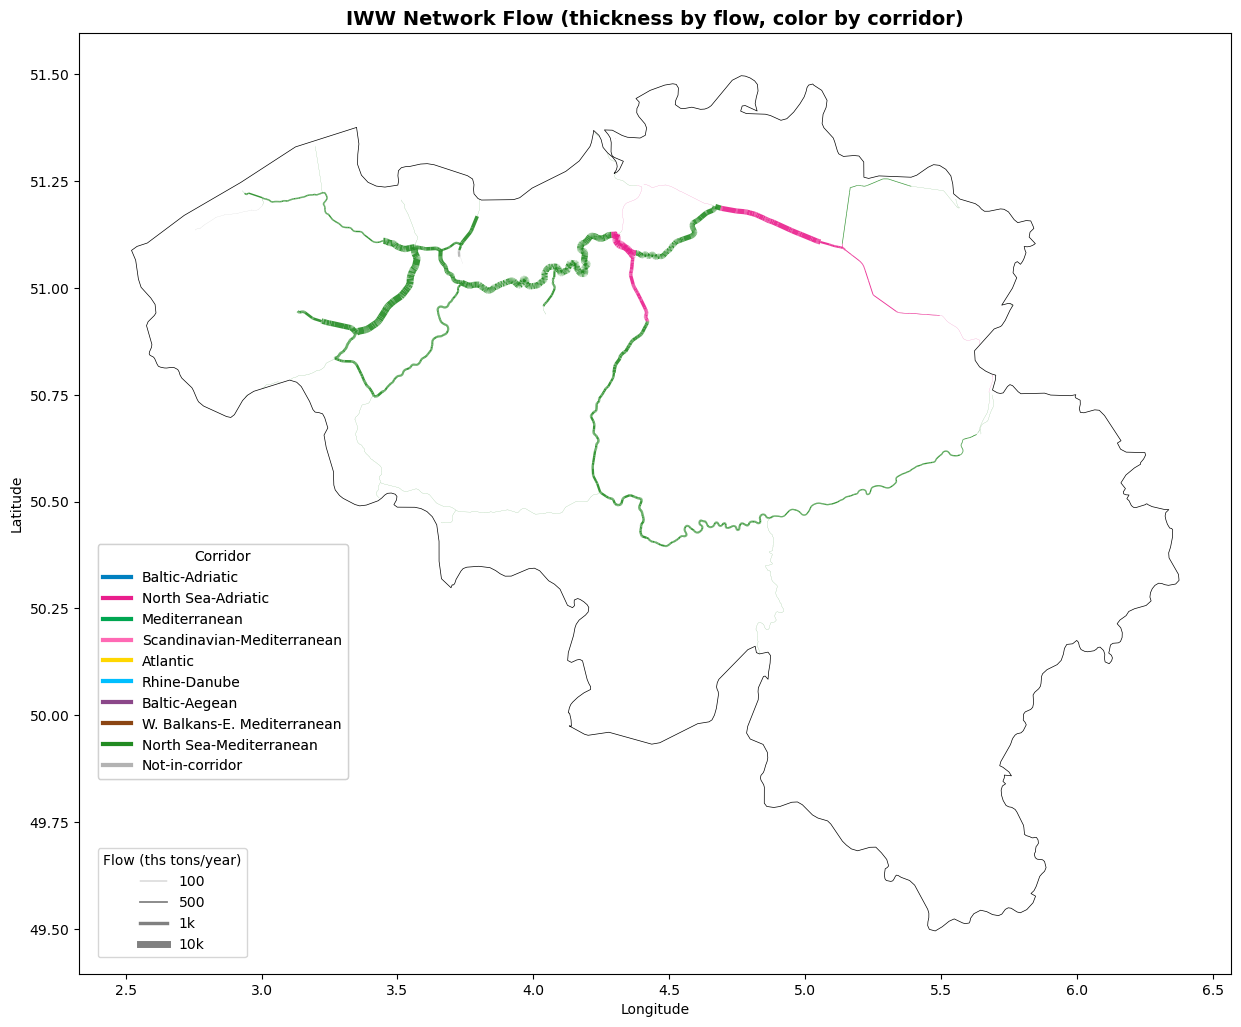

In [8]:
# Set the selected country
SELECTED_COUNTRY = "Belgium"

# Get country bounds using helper functions
belgium_row = europe_countries[europe_countries['NAME'].str.lower() == SELECTED_COUNTRY.lower()]
xlim, ylim = get_country_bounds(europe_countries, SELECTED_COUNTRY)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot flows
plot_edges_by_flow_thickness(
    ax, edges_gdf, flow_col='flow', corridors_col='CORRIDORS',
    lw_min=0.1, lw_max=5, scale='linear', scale_div=5, legend_ticks=[100, 500, 1000, 10000]
)

# Plot only Belgium outline
belgium_row.boundary.plot(ax=ax, color="black", linewidth=0.5)

# Set map extent
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.title("IWW Network Flow (thickness by flow, color by corridor)", fontsize=14, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.savefig(outpath / f'iww_network_flow_{SELECTED_COUNTRY.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')

plt.show()

## 8. Summary Statistics

This section provides summary statistics for the IWW network, OD matrix, and flow assignment, including network size, total flows, and flow distribution across edges.


In [9]:
print_network_flow_summary(g, iww_ports_gdf, od_flows, paths_df, edge_flow, n_edges,
                          flow_col='value', flow_unit='ths tons/year', network_type='IWW')

IWW FLOW ASSIGNMENT SUMMARY

Network:
  Nodes: 6,846
  Edges: 6,839
  Infrastructure nodes: 23

OD Matrix:
  Total OD pairs: 1,739
  Routable pairs: 7,655
  Total flow: 5,460 ths tons/year

Flow Assignment:
  Edges with flow: 4,636 / 6,839 (67.8%)
  Total flow on network: 20,407,051 ths tons/year
  Max edge flow: 10,436 ths tons/year
  Mean edge flow (non-zero): 4,402 ths tons/year

COMPLETE
